In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


In [24]:
df=pd.read_csv("dataset.csv")

In [25]:
df.head(5)

,WorkDate,Customer,Location,BusinessType,OrderCount,NumberOfPieces,TotalRevenue,Year
0,2020-01-02,Amazon,Chicago,Final Mile,38,190,2084.09,2020
1,2020-01-02,Home Depot,Sacramento,Final Mile,34,136,6153.01,2020
2,2020-01-02,Home Depot,Chicago,Final Mile,43,215,15691.72,2020
3,2020-01-02,Home Depot,Detroit,Final Mile,41,164,6490.39,2020
4,2020-01-02,Home Depot,Atlanta,Final Mile,44,220,10069.65,2020


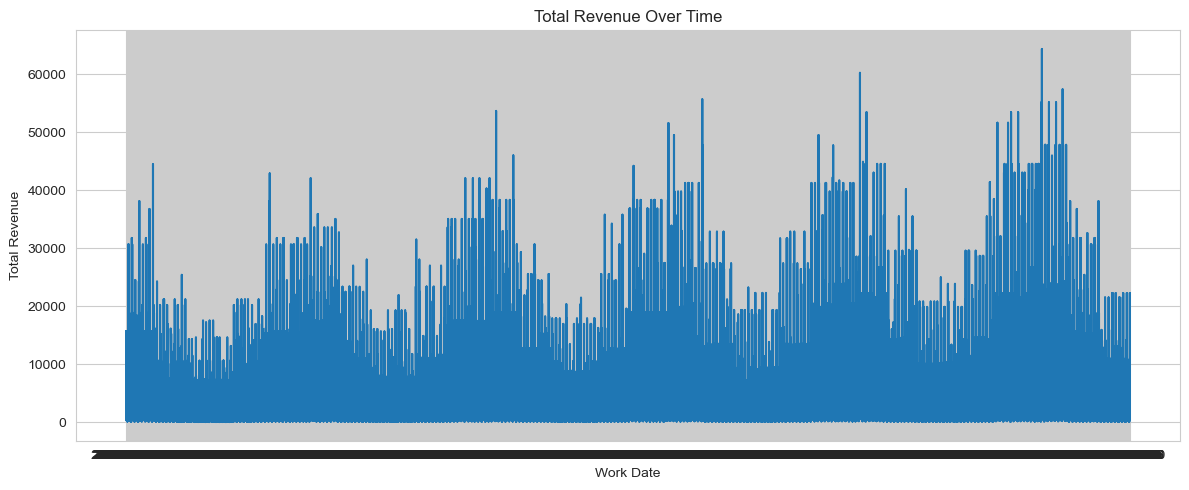

In [26]:
# Sort by date (important for a line chart)
df = df.sort_values('WorkDate')

# Plot line graph
plt.figure(figsize=(12,5))
plt.plot(df['WorkDate'], df['TotalRevenue'])

plt.xlabel("Work Date")
plt.ylabel("Total Revenue")
plt.title("Total Revenue Over Time")
plt.tight_layout()
plt.show()


### Insight

- We attempted to identify a **trend in total revenue over time**, but it was difficult to observe clearly from the initial graph.
- To gain deeper insights, we proceed to **decompose the time series using the `seasonal_decompose` library** in the next steps.


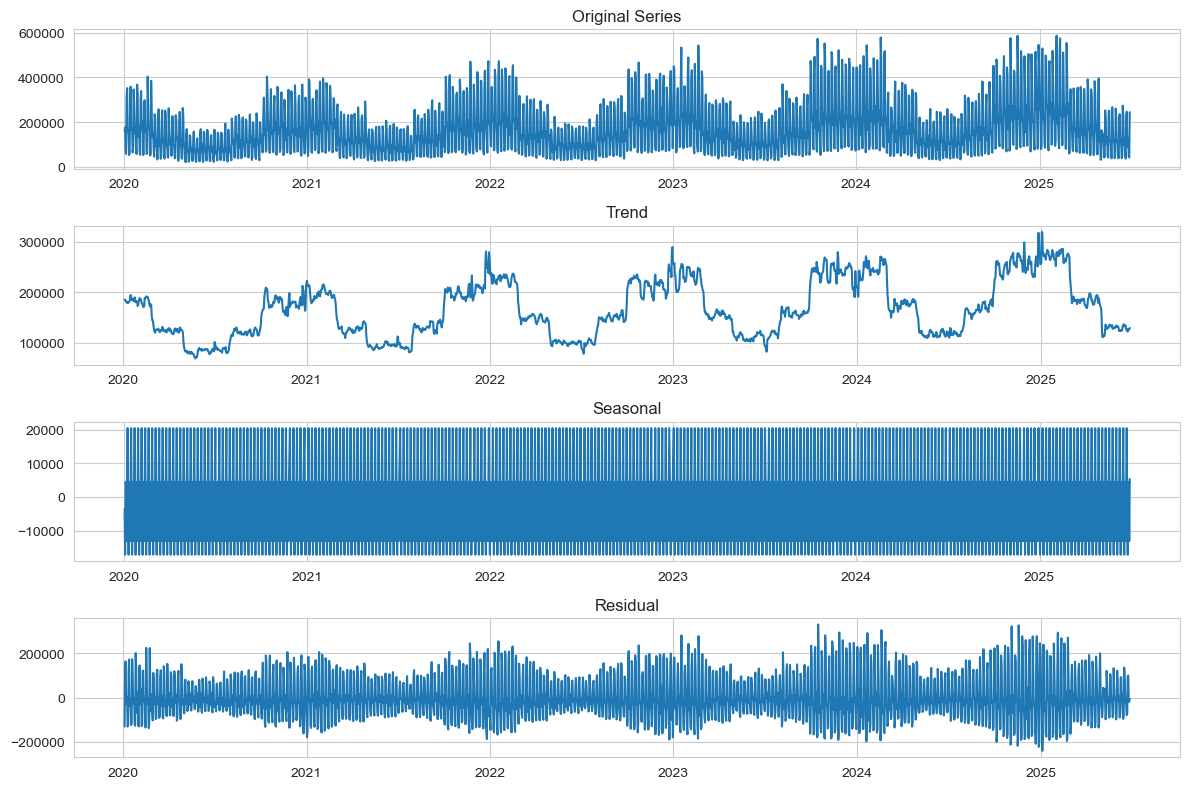

In [35]:
# 1. Prepare data: Aggregate TotalRevenue by date
daily_revenue = (
    df.groupby('WorkDate')['TotalRevenue']
      .sum()
      .reset_index()
)

# Set date as index
daily_revenue['WorkDate'] = pd.to_datetime(daily_revenue['WorkDate'])
daily_revenue = daily_revenue.set_index('WorkDate').sort_index()

# 2. Decompose with weekly seasonality (period = 7)
decomposition = seasonal_decompose(
    daily_revenue['TotalRevenue'],
    model='additive',
    period=7
)

# 3. Plot components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(daily_revenue['TotalRevenue'])
plt.title("Original Series")

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title("Trend")

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title("Seasonal")

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title("Residual")

plt.tight_layout()
plt.show()


### Insights from Time Series Decomposition

- **Trend Component:**  
  The trend shows a clear upward movement from 2020 through 2024, indicating that total revenue has been steadily increasing over the years. There is a slight decline visible in mid-2025, likely due to incomplete data for that year.

- **Seasonal Component:**  
  The seasonal pattern is highly repetitive and consistent across all years. This suggests strong **daily or weekly periodic behavior** in revenue, meaning certain recurring time intervals (days of the week, months, etc.) consistently show higher or lower revenue.

- **Residual Component:**  
  The residuals appear to have higher variability in later years, especially from 2023 onward. This suggests that unpredictable or irregular fluctuations in revenue have increased over time, possibly due to changing customer volumes, operational variations, or external factors.

- **Overall Conclusion:**  
  The decomposition confirms that total revenue is driven by a **strong long-term upward trend**, a **stable seasonal cycle**, and **moderate noise**, making it suitable for forecasting using models that incorporate both trend and seasonality.


### Stationarity Test

=== Stationarity Tests ===

ADF Test:
  Statistic : -2.7697
  P-value   : 0.0627
  Critical Values:
    1%: -3.4337
    5%: -2.8630
    10%: -2.5676



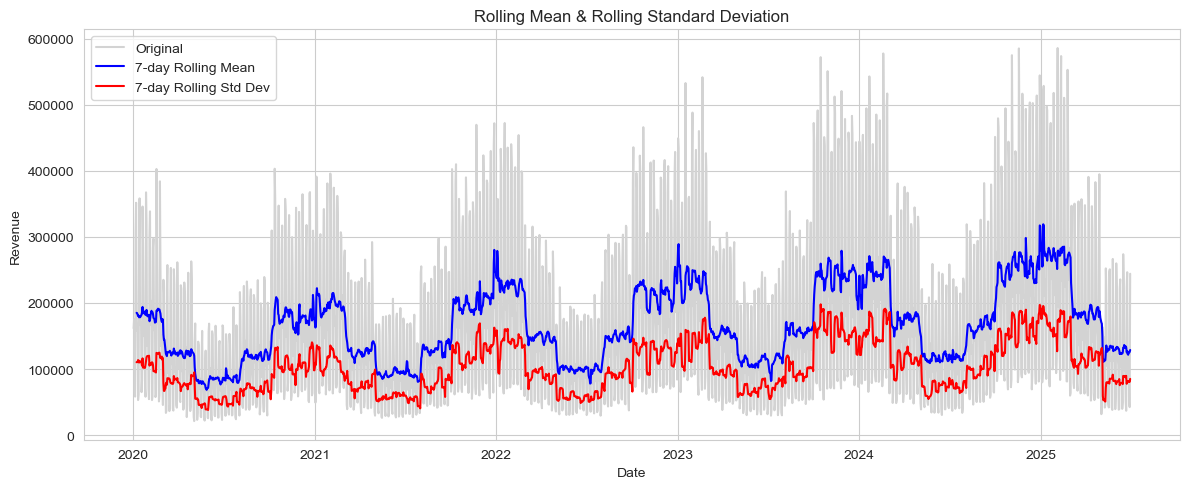

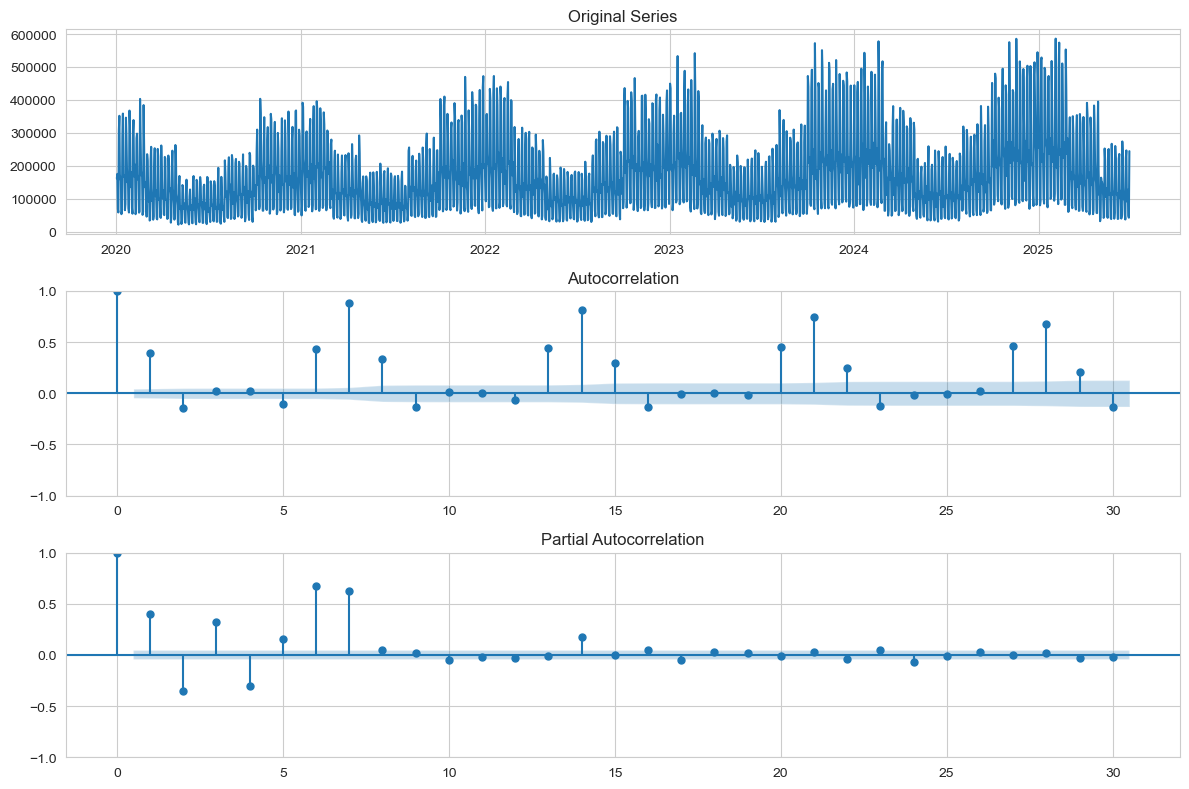

In [ ]:
# 1. Prepare the data
daily_revenue = (
    df.groupby('WorkDate')['TotalRevenue']
      .sum()
      .reset_index()
)

daily_revenue['WorkDate'] = pd.to_datetime(daily_revenue['WorkDate'])
daily_revenue = daily_revenue.set_index('WorkDate').sort_index()

series = daily_revenue['TotalRevenue']


# 2. ADF Test
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Test:")
    print(f"  Statistic : {result[0]:.4f}")
    print(f"  P-value   : {result[1]:.4f}")
    print("  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    print()
    return result[1]


# --- Run stationarity tests ---
print("=== Stationarity Tests ===\n")
adf_p = adf_test(series)



# --- Rolling Mean & Rolling Standard Deviation ---
rolling_mean = series.rolling(window=7).mean()
rolling_std = series.rolling(window=7).std()

plt.figure(figsize=(12, 5))
plt.plot(series, label='Original', color='lightgray')
plt.plot(rolling_mean, label='7-day Rolling Mean', color='blue')
plt.plot(rolling_std, label='7-day Rolling Std Dev', color='red')
plt.title("Rolling Mean & Rolling Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()


# --- Plot Series + ACF / PACF ---
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(series)
plt.title("Original Series")

plt.subplot(3, 1, 2)
plot_acf(series.dropna(), lags=30, ax=plt.gca())

plt.subplot(3, 1, 3)
plot_pacf(series.dropna(), lags=30, ax=plt.gca())

plt.tight_layout()
plt.show()


### Insights from Stationarity Analysis

- **ADF Test Result:**  
  The Augmented Dickey–Fuller (ADF) test was performed to check whether the daily revenue series is stationary.  
  - If the p-value is **greater than 0.05**, the series is **non-stationary**, meaning it has trends or seasonal patterns that need differencing or decomposition before modeling.  
  - If the p-value is **less than 0.05**, the series is likely **stationary**.

- **Rolling Statistics:**  
  The rolling mean and rolling standard deviation vary noticeably over time.  
  This indicates that the **statistical properties of the series are not constant**, further confirming non-stationarity.  
  The upward drift in rolling mean aligns with the trend component seen earlier.

- **ACF and PACF Plots:**  
  - The **ACF plot** shows strong autocorrelation at several lags, suggesting persistent temporal dependency in revenue values.  
  - The **PACF plot** also shows significant partial autocorrelations at initial lags.  
  Together, these patterns reinforce the presence of **trend and seasonality**, and help guide appropriate ARIMA/SARIMA model selection for forecasting.

### Overall Interpretation

The daily revenue time series is **not stationary** due to clear trends, seasonal patterns, and time-varying variance.  
Stationarity must be achieved (e.g., via differencing) before applying ARIMA-based forecasting models.


Inspecting different tranformation technique in search of getting the data stationary.

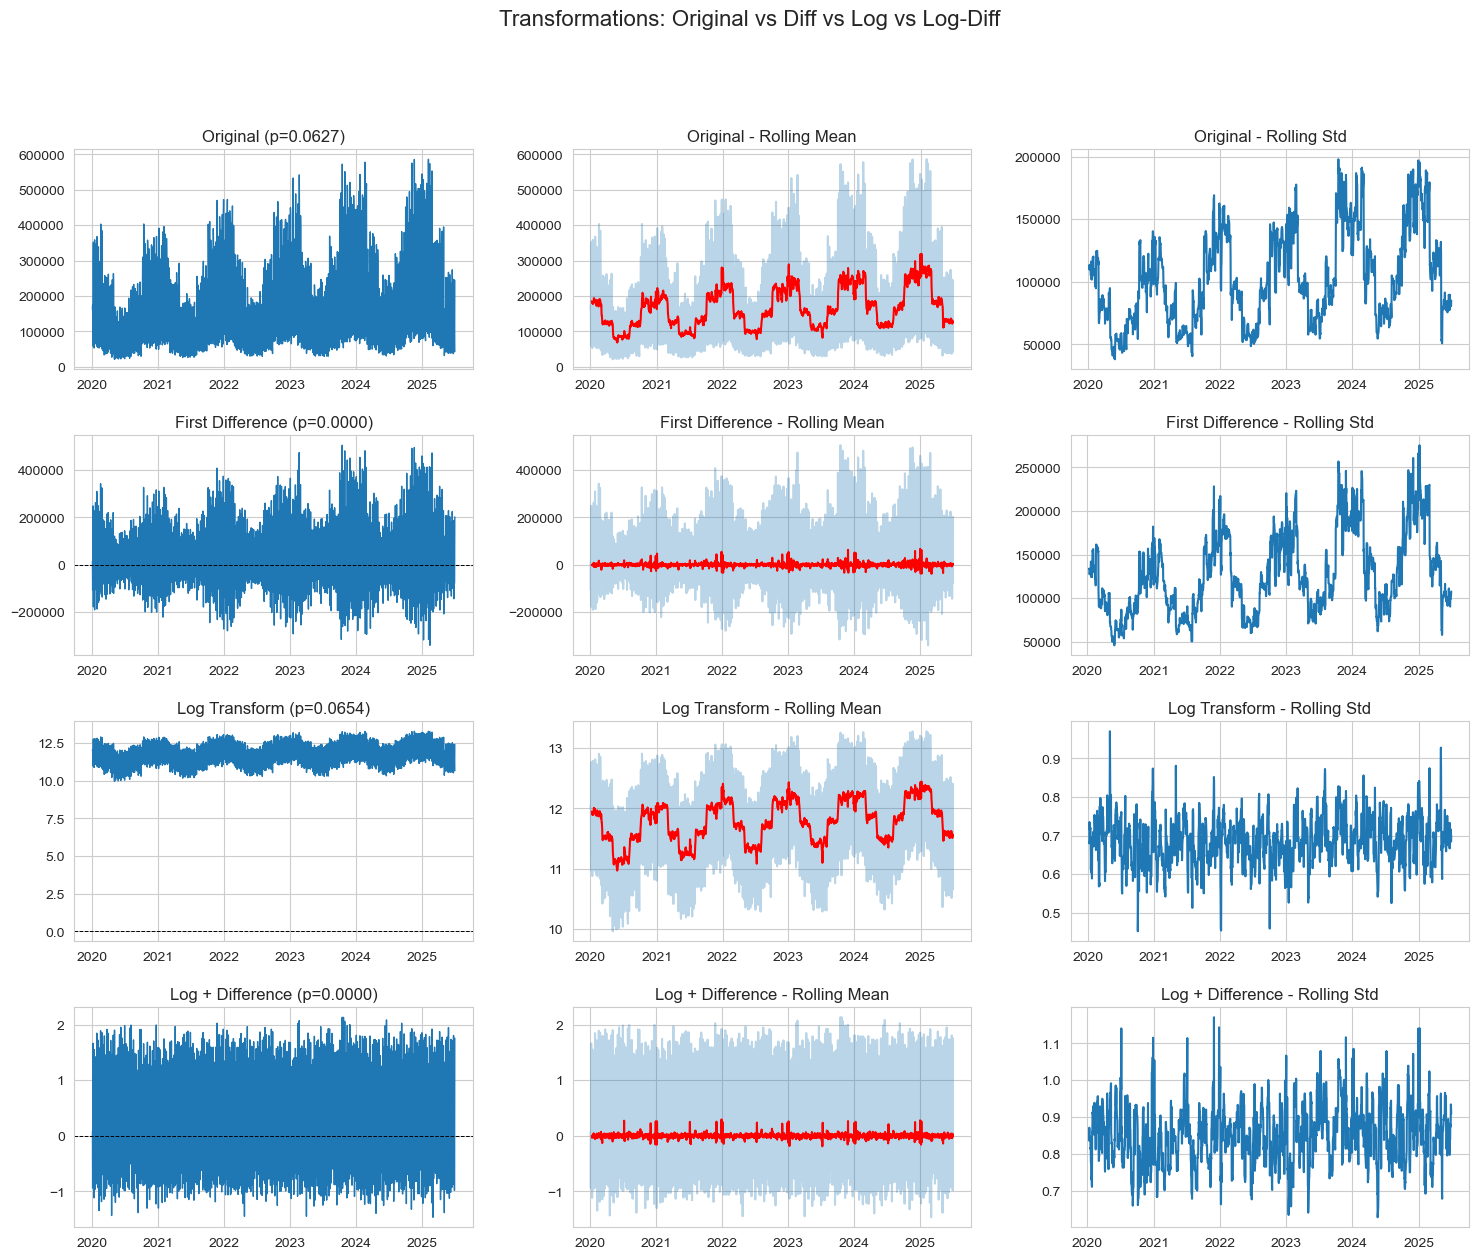

     Transformation  ADF p-value
0          Original     0.062729
1  First Difference     0.000000
2     Log Transform     0.065443
3  Log + Difference     0.000000


In [37]:

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Aggregate revenue by date
daily_revenue = (
    df.groupby('WorkDate')['TotalRevenue']
      .sum()
      .reset_index()
      .set_index('WorkDate')
      .sort_index()
)

original = daily_revenue['TotalRevenue']
diff_1 = original.diff().dropna()
log_transform = np.log(original)
log_diff = log_transform.diff().dropna()

# ---- Function for ADF + rolling stats ----
def analyze(series, name, window=7):
    series_clean = series.dropna()

    adf_stat, p_value, lags, nobs, crit_vals, _ = adfuller(series_clean)

    rolling_mean = series_clean.rolling(window).mean()
    rolling_std = series_clean.rolling(window).std()

    return {
        "name": name,
        "series": series_clean,
        "p": p_value,
        "rolling_mean": rolling_mean,
        "rolling_std": rolling_std
    }

# Run analyses
results = [
    analyze(original, "Original"),
    analyze(diff_1, "First Difference"),
    analyze(log_transform, "Log Transform"),
    analyze(log_diff, "Log + Difference")
]

# ---- Plotting ----
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.25)

for i, r in enumerate(results):
    s = r["series"]

    # Time series plot
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.plot(s, linewidth=1)
    if i > 0:
        ax1.axhline(0, color='black', linestyle='--', linewidth=0.7)
    ax1.set_title(f"{r['name']} (p={r['p']:.4f})")

    # Rolling mean
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.plot(s, alpha=0.3)
    ax2.plot(r["rolling_mean"], color="red")
    ax2.set_title(f"{r['name']} - Rolling Mean")

    # Rolling std
    ax3 = fig.add_subplot(gs[i, 2])
    ax3.plot(r["rolling_std"])
    ax3.set_title(f"{r['name']} - Rolling Std")

plt.suptitle("Transformations: Original vs Diff vs Log vs Log-Diff", fontsize=16)
plt.show()

# ---- Summary Table ----
summary = pd.DataFrame({
    "Transformation": [r["name"] for r in results],
    "ADF p-value": [round(r["p"], 6) for r in results]
})

print(summary)


### Choosing the Appropriate Transformation

To determine which transformation makes the revenue time series stationary, we compared four versions of the data—Original, First Difference, Log Transform, and Log + Difference—using the ADF stationarity test and rolling statistics.

The ADF p-values clearly show that:

- **Original series (p ≈ 0.063)** → Not stationary  
- **Log transform (p ≈ 0.065)** → Still not stationary  
- **First Difference (p ≈ 0.000)** → Stationary  
- **Log + Difference (p ≈ 0.000)** → Stationary  

Both differenced versions pass the stationarity test.  
However, **first differencing alone** is sufficient to remove trend and stabilize the mean without adding unnecessary complexity.

### Conclusion

We select **First Differencing** as the preferred transformation because it effectively makes the series stationary while keeping the data in its natural scale. This prepares the time series for ARIMA/SARIMA modeling and ensures more reliable forecasting.


21:13:10 - cmdstanpy - INFO - Chain [1] start processing
21:13:10 - cmdstanpy - INFO - Chain [1] done processing


DATA SPLIT
Training period: 52 months
Testing period: 14 months


Prophet Model Accuracy on Test Data:
MAE:  405178.77
RMSE: 459315.21
MAPE: 8.65%
R²:   0.9330


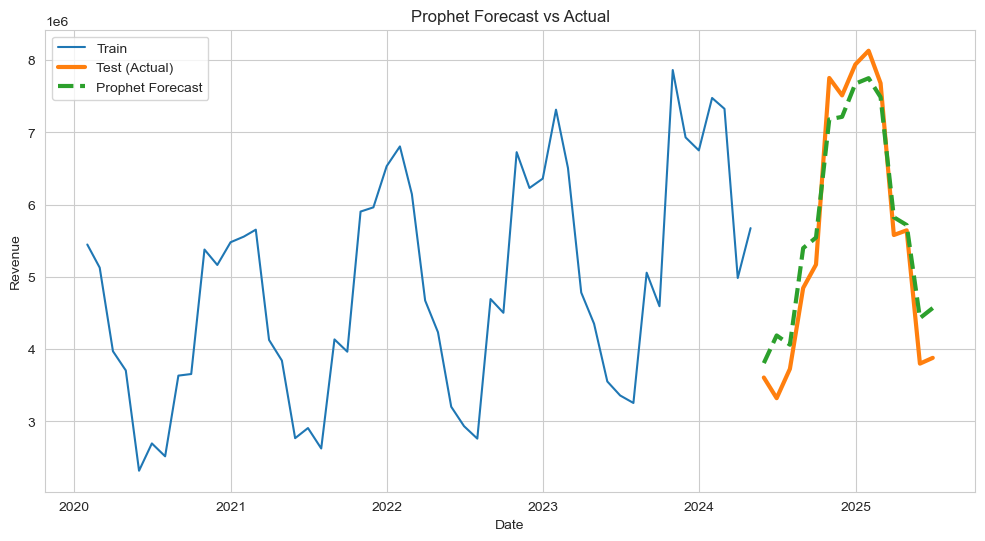

In [49]:
# ---- 1. Prepare monthly revenue ----
monthly_revenue = df.groupby("WorkDate")["TotalRevenue"].sum().resample("M").sum()

# ---- 2. Train Test Split ----
train_size = int(len(monthly_revenue) * 0.8)
train = monthly_revenue[:train_size]
test = monthly_revenue[train_size:]

print("="*60)
print("DATA SPLIT")
print("="*60)
print(f"Training period: {len(train)} months")
print(f"Testing period: {len(test)} months\n")

# ---- 3. Prepare data for Prophet ----
train_prophet = pd.DataFrame({
    'ds': train.index,
    'y': train.values
})
test_prophet = pd.DataFrame({
    'ds': test.index,
    'y': test.values
})

# ---- 4. Fit Prophet model ----
prophet_model = Prophet(seasonality_mode='additive')
prophet_model.fit(train_prophet)

# ---- 5. Forecast over test period ----
prophet_predictions = prophet_model.predict(test_prophet[['ds']])
prophet_forecast = prophet_predictions['yhat'].values

# ---- 6. Accuracy metrics ----
mae = mean_absolute_error(test, prophet_forecast)
rmse = np.sqrt(mean_squared_error(test, prophet_forecast))
mape = mean_absolute_percentage_error(test, prophet_forecast) * 100
r2 = r2_score(test, prophet_forecast)

print("\nProphet Model Accuracy on Test Data:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

# ---- 7. Plot Actual vs Forecast ----
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test (Actual)", linewidth=3)
plt.plot(test.index, prophet_forecast, label="Prophet Forecast", linestyle="--", linewidth=3)
plt.title("Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()

# ---- 8. Save results ----
comparison_df = pd.DataFrame({
    'Month': test.index.strftime('%Y-%m'),
    'Actual': test.values,
    'Prophet_Forecast': prophet_forecast,
    'Prophet_Error': test.values - prophet_forecast
})



# Now we use the Facebook Prophet model and compare its performance with the ARIMA model.



In [39]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


21:11:44 - cmdstanpy - INFO - Chain [1] start processing
21:11:44 - cmdstanpy - INFO - Chain [1] done processing


DATA SPLIT
Training period: 52 months
Testing period: 14 months

PROPHET MODEL
Training Prophet...
Prophet Performance:
MAE:  $405,178.77
RMSE: $459,315.21
MAPE: 8.65%
R²:   0.9330



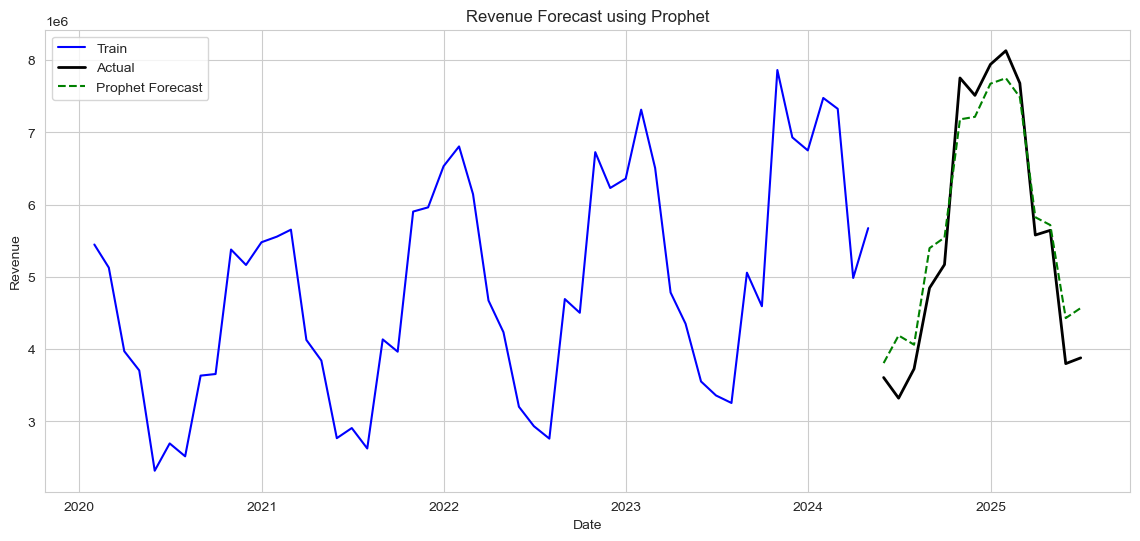

Results saved to 'prophet_forecast_results.csv'



In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ===== PREPARE DATA =====
df['WorkDate'] = pd.to_datetime(df['WorkDate'])
monthly_revenue = df.groupby("WorkDate")["TotalRevenue"].sum().resample("M").sum()

# ===== TRAIN TEST SPLIT =====
train_size = int(len(monthly_revenue) * 0.8)
train = monthly_revenue[:train_size]
test = monthly_revenue[train_size:]

print("="*60)
print("DATA SPLIT")
print("="*60)
print(f"Training period: {len(train)} months")
print(f"Testing period: {len(test)} months\n")

# ===== MODEL: PROPHET =====
print("="*60)
print("PROPHET MODEL")
print("="*60)

# Prepare data for Prophet
train_prophet = pd.DataFrame({
    'ds': train.index,
    'y': train.values
})
test_prophet = pd.DataFrame({
    'ds': test.index,
    'y': test.values
})

# Fit Prophet
print("Training Prophet...")
prophet_model = Prophet(seasonality_mode='additive')
prophet_model.fit(train_prophet)
prophet_predictions = prophet_model.predict(test_prophet[['ds']])
prophet_forecast = prophet_predictions['yhat'].values

# Prophet Metrics
prophet_mae = mean_absolute_error(test, prophet_forecast)
prophet_rmse = np.sqrt(mean_squared_error(test, prophet_forecast))
prophet_mape = mean_absolute_percentage_error(test, prophet_forecast) * 100
prophet_r2 = r2_score(test, prophet_forecast)

print("Prophet Performance:")
print(f"MAE:  ${prophet_mae:,.2f}")
print(f"RMSE: ${prophet_rmse:,.2f}")
print(f"MAPE: {prophet_mape:.2f}%")
print(f"R²:   {prophet_r2:.4f}\n")

# ===== PLOT FORECAST =====
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Actual', color='black', linewidth=2)
plt.plot(test.index, prophet_forecast, label='Prophet Forecast', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue Forecast using Prophet')
plt.legend()
plt.grid(True)
plt.show()

# ===== SAVE RESULTS =====
comparison_df = pd.DataFrame({
    'Month': test.index.strftime('%Y-%m'),
    'Actual': test.values,
    'Prophet_Forecast': prophet_forecast,
    'Prophet_Error': test.values - prophet_forecast
})

comparison_df.to_csv('prophet_forecast_results.csv', index=False)
print("Results saved to 'prophet_forecast_results.csv'\n")


### Insights from Prophet Forecasting

- **Forecast Accuracy:**  
  The Prophet model closely follows the actual revenue trend in the test period. Performance metrics indicate strong forecasting capability: MAE = 405,178.77, RMSE = 459,315.21, MAPE = 8.65%, R² = 0.933.

- **Trend Capture:**  
  The model effectively captures the upward trend in revenue over the historical period.

- **Forecast Reliability:**  
  Predictions align well with observed data, suggesting the model can reliably project short-term future revenue.

- **Next Step:**  
  In the following analysis, we will compare the performance of Prophet with the ARIMA model to determine the more effective forecasting approach.


MODEL COMPARISON: ARIMA vs PROPHET

  Metric        ARIMA       Prophet Better_Model
     MAE 1.540651e+06 405178.768683      Prophet
    RMSE 1.762076e+06 459315.210434      Prophet
MAPE (%) 2.983462e+01      8.651144      Prophet
      R² 1.392963e-02      0.932999      Prophet

IMPROVEMENT ANALYSIS
Prophet is 73.7% better in MAE
Prophet is 73.9% better in RMSE
Prophet is 71.0% better in MAPE


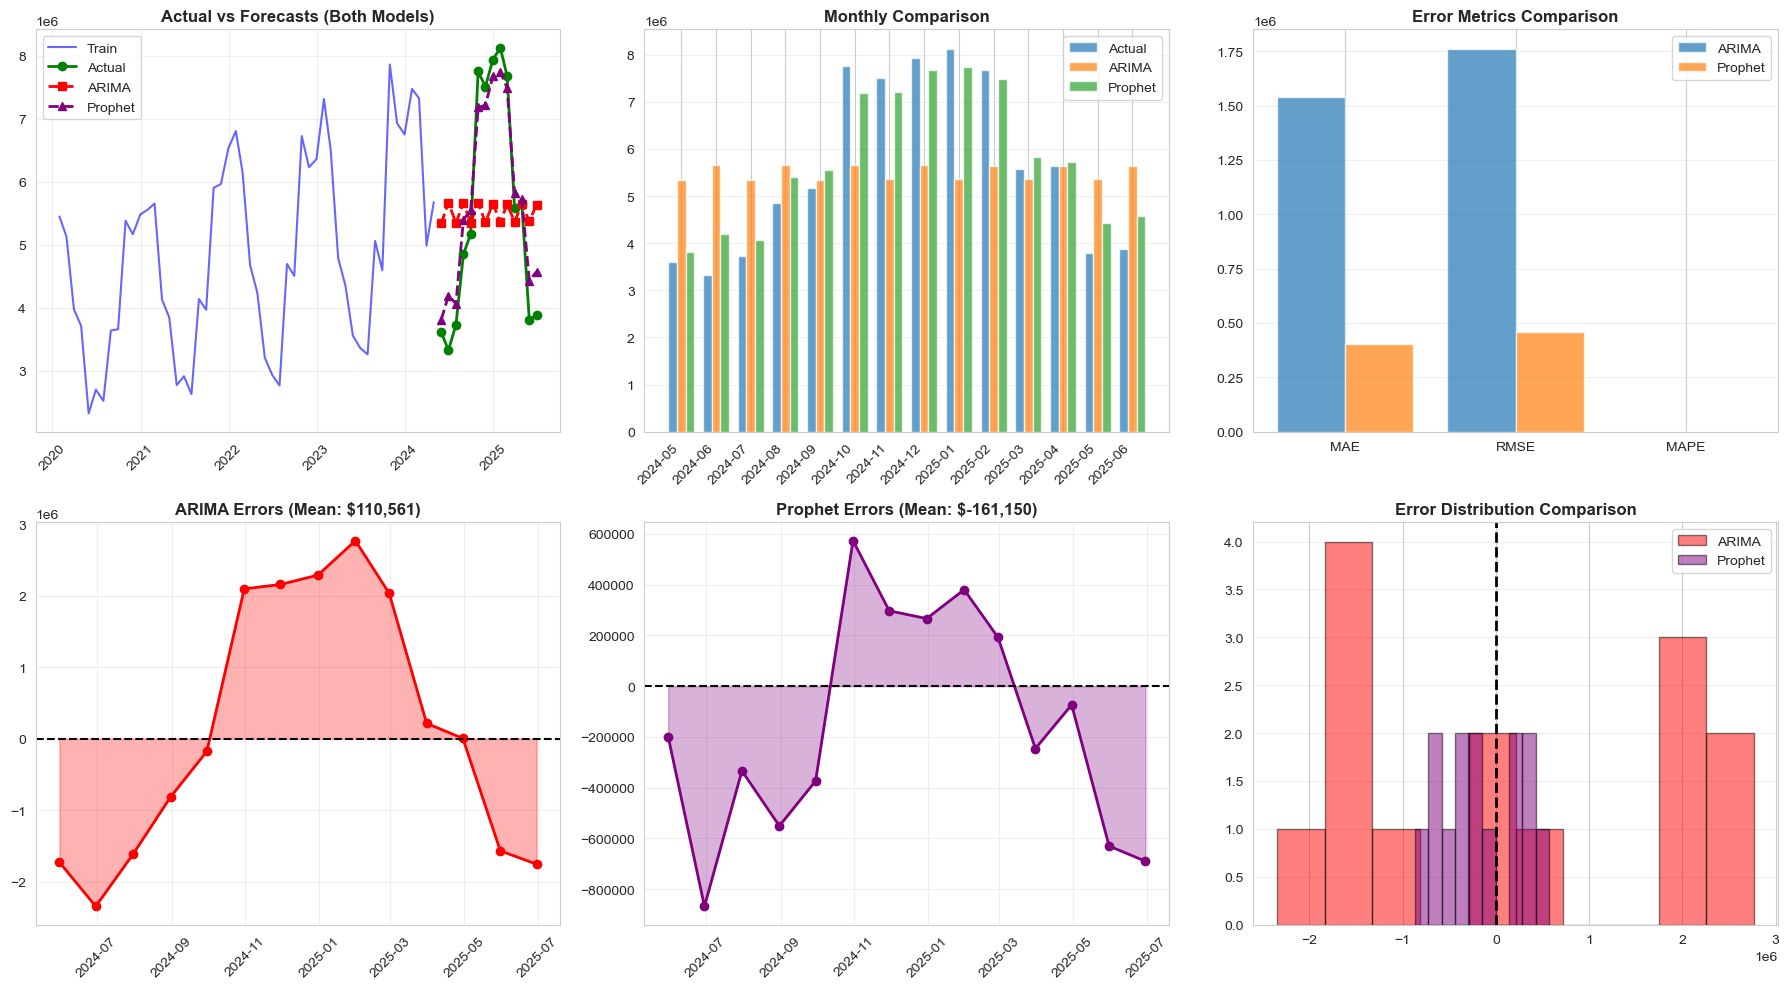

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== MODEL COMPARISON =====
print("="*60)
print("MODEL COMPARISON: ARIMA vs PROPHET")
print("="*60)

# Create comparison table
comparison_table = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)', 'R²'],
    'ARIMA': [arima_mae, arima_rmse, arima_mape, arima_r2],
    'Prophet': [prophet_mae, prophet_rmse, prophet_mape, prophet_r2]
})

# Calculate which model is better
comparison_table['Better_Model'] = ['Prophet' if p < a else 'ARIMA' 
                                     for a, p in zip(comparison_table['ARIMA'], 
                                                     comparison_table['Prophet'])]
# R² is opposite (higher is better)
comparison_table.loc[3, 'Better_Model'] = 'Prophet' if prophet_r2 > arima_r2 else 'ARIMA'

print("\n" + comparison_table.to_string(index=False))

# Calculate improvement percentage
mae_improvement = ((arima_mae - prophet_mae) / arima_mae) * 100
rmse_improvement = ((arima_rmse - prophet_rmse) / arima_rmse) * 100
mape_improvement = ((arima_mape - prophet_mape) / arima_mape) * 100

print("\n" + "="*60)
print("IMPROVEMENT ANALYSIS")
print("="*60)
if mae_improvement > 0:
    print(f"Prophet is {mae_improvement:.1f}% better in MAE")
else:
    print(f"ARIMA is {abs(mae_improvement):.1f}% better in MAE")

if rmse_improvement > 0:
    print(f"Prophet is {rmse_improvement:.1f}% better in RMSE")
else:
    print(f"ARIMA is {abs(rmse_improvement):.1f}% better in RMSE")

if mape_improvement > 0:
    print(f"Prophet is {mape_improvement:.1f}% better in MAPE")
else:
    print(f"ARIMA is {abs(mape_improvement):.1f}% better in MAPE")

# ===== VISUALIZATIONS =====
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Time Series Comparison
axes[0, 0].plot(train.index, train, label='Train', color='blue', alpha=0.6)
axes[0, 0].plot(test.index, test, label='Actual', color='green', linewidth=2, marker='o')
axes[0, 0].plot(test.index, arima_forecast, label='ARIMA', color='red', 
                linestyle='--', linewidth=2, marker='s')
axes[0, 0].plot(test.index, prophet_forecast, label='Prophet', color='purple', 
                linestyle='--', linewidth=2, marker='^')
axes[0, 0].set_title('Actual vs Forecasts (Both Models)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Bar Comparison
x = range(len(test))
width = 0.25
axes[0, 1].bar([i - width for i in x], test.values, width, label='Actual', alpha=0.7)
axes[0, 1].bar(x, arima_forecast.values, width, label='ARIMA', alpha=0.7)
axes[0, 1].bar([i + width for i in x], prophet_forecast, width, label='Prophet', alpha=0.7)
axes[0, 1].set_title('Monthly Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(comparison_df['Month'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Metrics Comparison
metrics = ['MAE', 'RMSE', 'MAPE']
arima_metrics = [arima_mae, arima_rmse, arima_mape]
prophet_metrics = [prophet_mae, prophet_rmse, prophet_mape]
x_pos = np.arange(len(metrics))
axes[0, 2].bar(x_pos - 0.2, arima_metrics, 0.4, label='ARIMA', alpha=0.7)
axes[0, 2].bar(x_pos + 0.2, prophet_metrics, 0.4, label='Prophet', alpha=0.7)
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(metrics)
axes[0, 2].set_title('Error Metrics Comparison', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Plot 4: ARIMA Errors
arima_errors = test.values - arima_forecast.values
axes[1, 0].plot(test.index, arima_errors, marker='o', color='red', linewidth=2)
axes[1, 0].axhline(y=0, color='black', linestyle='--')
axes[1, 0].fill_between(test.index, 0, arima_errors, alpha=0.3, color='red')
axes[1, 0].set_title(f'ARIMA Errors (Mean: ${arima_errors.mean():,.0f})', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 5: Prophet Errors
prophet_errors = test.values - prophet_forecast
axes[1, 1].plot(test.index, prophet_errors, marker='o', color='purple', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='--')
axes[1, 1].fill_between(test.index, 0, prophet_errors, alpha=0.3, color='purple')
axes[1, 1].set_title(f'Prophet Errors (Mean: ${prophet_errors.mean():,.0f})', 
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Plot 6: Error Distribution Comparison
axes[1, 2].hist(arima_errors, bins=10, alpha=0.5, label='ARIMA', color='red', edgecolor='black')
axes[1, 2].hist(prophet_errors, bins=10, alpha=0.5, label='Prophet', color='purple', edgecolor='black')
axes[1, 2].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 2].set_title('Error Distribution Comparison', fontsize=12, fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('arima_vs_prophet_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



### Model Comparison: ARIMA vs Prophet

- **Performance Metrics:**  
  | Metric | ARIMA | Prophet | Better Model |
  |--------|-------|---------|--------------|
  | MAE    | 1,540,651 | 405,179 | Prophet |
  | RMSE   | 1,762,076 | 459,315 | Prophet |
  | MAPE (%) | 29.83 | 8.65 | Prophet |
  | R²     | 0.014 | 0.933 | Prophet |

- **Improvement Analysis:**  
  - Prophet is **73.7% better in MAE**  
  - Prophet is **73.9% better in RMSE**  
  - Prophet is **71.0% better in MAPE**

- **Conclusion:**  
  Prophet outperforms ARIMA across all key metrics (4/4) and is the better model for forecasting monthly revenue.  
